# **Generating Handwritten Digits with a GAN**

## Imports

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten) 
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/CS4701/source')

In [5]:
from generators import make_default_dcgan_generator, make_gan_generator_v1, make_gan_generator_v2, make_gan_generator_v3, make_gan_generator_v4
from discriminators import make_default_gcgan_discriminator, make_gan_discriminator_v1, make_gan_discriminator_v2, make_gan_discriminator_v3, make_gan_discriminator_v4

## **Customize GAN**

In [74]:
generator_key_mapping = {
    'default_dcgan': make_default_dcgan_generator,
    'gan_v1': make_gan_generator_v1,
    'gan_v2': make_gan_generator_v2,
    'gan_v3': make_gan_generator_v3,
    'gan_v4': make_gan_generator_v4,
}

#@title Select a Generator Model { form-width: "30%" }
generator_model = "default_dcgan" #@param ["default_dcgan", "gan_v1", "gan_v2", "gan_v3", "gan_v4"]


generator = generator_key_mapping[generator_model]()

In [75]:
discriminator_key_mapping = {
    'default_dcgan': make_default_gcgan_discriminator,
    'gan_v1': make_gan_discriminator_v1,
    'gan_v2': make_gan_discriminator_v2,
    'gan_v3': make_gan_discriminator_v3,
    'gan_v4': make_gan_discriminator_v4,
}

#@title Select a Discriminator Model { form-width: "30%" }
discriminator_model = "default_dcgan" #@param ["default_dcgan", "gan_v1", "gan_v2", "gan_v3", "gan_v4"]


discriminator = discriminator_key_mapping[discriminator_model]()

In [71]:
#@title Select Parameter Values { form-width: "30%" }
BUFFER_SIZE = 60000 #@param {type:"number"}
BATCH_SIZE =  256#@param {type:"number"}

# noise_dim should be equal to the input size of your generator
noise_dim = 100 #@param {type:"number"}

optimizer_key_mapping = {
    'default_adam': tf.keras.optimizers.Adam(1e-5)
}

generator_opt = 'default_adam' #@param ["default_adam"]
discriminator_opt = 'default_adam' #@param ["default_adam"]

generator_optimizer = optimizer_key_mapping[generator_opt]
discriminator_optimizer = optimizer_key_mapping[discriminator_opt]

EPOCHS = 20#@param {type:"number"}

#### Model Sanity Check

(1, 1)
Discriminator Decision: tf.Tensor([[0.00014828]], shape=(1, 1), dtype=float32)


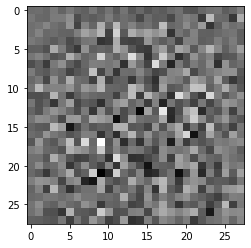

In [76]:
# Can untrained Generator generate random Images? 
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# Does untrained Discriminator output a reasonable (scalar) value?
decision = discriminator(generated_image)
print(decision.shape)
print ("Discriminator Decision:", decision)

#### View Model Summaries

In [77]:
generator.summary()
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_6 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 7, 7, 128)      

## **Download and Batch Training Dataset**

In [57]:
# underscore to omit the label arrays
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## **Train the Generator and Discriminator models**

#### Create loss functions for generator and discriminator

In [58]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### Define checkpointing paths and random seed

In [59]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [60]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

#### Define a custom training step (generator and descriminator must be trained simultaniously)

In [61]:
# tf.function annotation causes the function
# to be "compiled" as part of the training
@tf.function
def train_step(images):
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#### Define Training Function

In [62]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 3 - Save the model every 5 epochs as 
    # a checkpoint, which we will use later
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

#### Function to actually generate images

In [63]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Train!

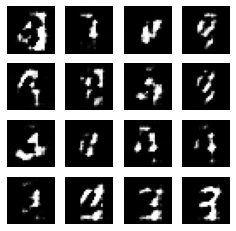

In [64]:
train(train_dataset, EPOCHS)

### Restore Model Checkpoint

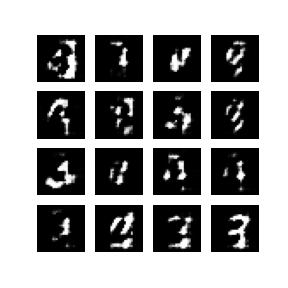

In [65]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# PIL is a library which may open different image file formats
import PIL 
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

### Visualize the training!

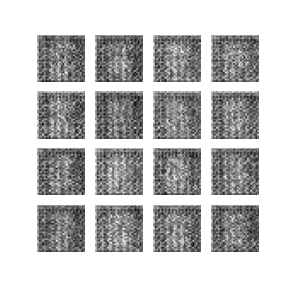

In [66]:

import glob # The glob module is used for Unix style pathname pattern expansion.
import imageio # The library that provides an easy interface to read and write a wide range of image data

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  # image = imageio.imread(filename)
  # writer.append_data(image)
  
display.Image(open('dcgan.gif','rb').read())

## **Save Generator Model to Google Drive**



In [67]:
#@title Select a name for your model { form-width: "30%" }
base_drive_path = '/content/drive/MyDrive/CS4701/source/saved_models'

# Try to give the model a descriptive name: e.g. default_dcgan_20epochs
model_name = 'default_20' #@param {type:"string"}

full_path = f'{base_drive_path}/{model_name}'

In [68]:
# Only need to save the generator because we only need to save the model for
# For image generation, and the discriminator doesn't generate images
generator.save(full_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS4701/source/saved_models/default_20/assets
